Оригинальная матрица F:
 [[2.00000000e+00 4.71844785e-16 7.00000000e+00]
 [1.15470054e+00 2.00000000e+00 8.15470054e+00]
 [0.00000000e+00 8.32667268e-17 1.00000000e+00]]

Разложенная матрица F:
 [[ 2.82842712 -1.          6.82842712]
 [ 1.63299316  1.73205081  8.36504397]
 [ 0.          0.          1.        ]]

Разница между матрицами:
[[8.28427125e-01 1.00000000e+00 1.71572875e-01]
 [4.78292623e-01 2.67949192e-01 2.10343431e-01]
 [0.00000000e+00 8.32667268e-17 0.00000000e+00]]


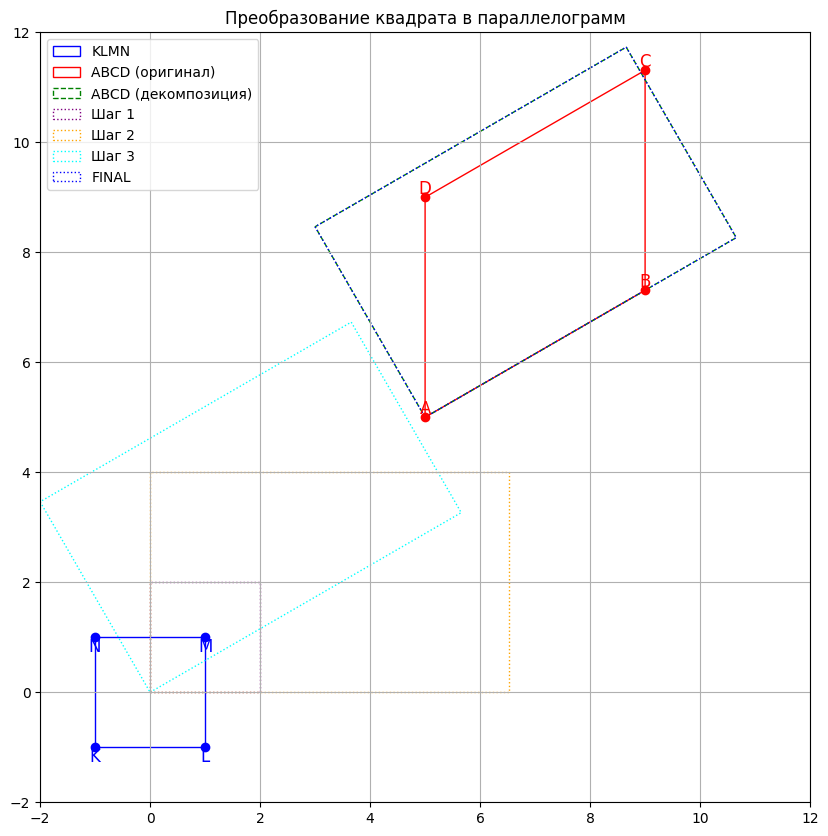


Матрица переноса T1 (K в начало координат):
[[1 0 1]
 [0 1 1]
 [0 0 1]]

Матрица масштабирования S:
[[3.26598632 0.         0.        ]
 [0.         2.         0.        ]
 [0.         0.         1.        ]]

Матрица поворота R:
[[ 0.8660254 -0.5        0.       ]
 [ 0.5        0.8660254  0.       ]
 [ 0.         0.         1.       ]]

Матрица переноса T2 (в точку A):
[[1 0 5]
 [0 1 5]
 [0 0 1]]

Проверка: полученный F_decomposed = T2 · R · S · T1
Элементарные преобразования:
1. Перенос K в начало координат
2. Масштабирование по x и y в нужных пропорциях
3. Поворот для получения угла π/3
4. Перенос в точку A


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D

# ---------- Вспомогательные функции ----------
def apply_transform(points, mat):
    """
    Применяет аффинную матрицу mat (3x3) к набору декартовых точек (N×2).
    Возвращает массив N×2.
    """
    homog = np.hstack([points, np.ones((points.shape[0],1))])  
    transformed = homog @ mat.T
    return transformed[:, :2]

# ----- Исходный квадрат KLMN -----
# Пусть K=(-1,-1), L=(1,-1), M=(1,1), N=(-1,1).
K = np.array([-1, -1])
L = np.array([ 1, -1])
M = np.array([ 1,  1])
N = np.array([-1,  1])
square = np.vstack([K,L,M,N])
square_hom = np.column_stack((square, np.ones(4)))  # Однородные координаты

# ----- Параметры преобразования как в исходном коде -----
A = K + 3*(M - K)
D = A + 2*(N - K)
angle_AB = np.pi/6
dir_AB = np.array([np.cos(angle_AB), np.sin(angle_AB)])
length_AB = 4 / np.sin(np.pi/3)
AB_vec = length_AB * dir_AB
B = A + AB_vec
C = B + (D - A)

# Собираем вершины ABCD
ABCD = np.vstack([A,B,C,D])
ABCD_hom = np.column_stack((ABCD, np.ones(4)))

# ----- Оригинальная матрица F из исходного кода -----
F_original = ABCD_hom.T @ np.linalg.pinv(square_hom.T)
print("Оригинальная матрица F:\n", F_original)

# ----- Элементарные преобразования -----
# 1. Перенос K в начало координат
T1 = np.array([
    [1, 0, -K[0]],
    [0, 1, -K[1]],
    [0, 0, 1]
])

# 2. Масштабирование 
# Вычислим коэффициенты масштабирования, которые нам нужны
# Расстояние |A-D| должно быть в 2 раза больше |K-N|
scale_y = 2  # По условию образ KN в 2 раза больше

# Вычисляем масштаб по x так, чтобы угол был π/3
# Масштаб по x должен обеспечить нужное соотношение сторон
scale_x = length_AB / np.sqrt(2)  # 2√2 - это длина диагонали квадрата со стороной 2

S = np.array([
    [scale_x, 0, 0],
    [0, scale_y, 0],
    [0, 0, 1]
])

# 3. Поворот так, чтобы угол при вершине A был π/3
theta = np.pi/6  # 30 градусов, чтобы получить угол π/3 между сторонами
R = np.array([
    [np.cos(theta), -np.sin(theta), 0],
    [np.sin(theta), np.cos(theta), 0], 
    [0, 0, 1]
])

# 4. Перенос в точку A
T2 = np.array([
    [1, 0, A[0]],
    [0, 1, A[1]],
    [0, 0, 1]
])

# Комбинируем все преобразования: F = T2 * R * S * T1
F_decomposed = T2 @ R @ S @ T1
print("\nРазложенная матрица F:\n", F_decomposed)

# Сравниваем с оригинальной матрицей F
print("\nРазница между матрицами:")
print(np.abs(F_original - F_decomposed))

# ----- Проверяем наше разложение -----
# Сначала применяем оригинальную матрицу F
transformed_original = apply_transform(square, F_original)

# Затем применяем последовательно наши элементарные преобразования
step1 = apply_transform(square, T1)
step2 = apply_transform(step1, S)
step3 = apply_transform(step2, R)
final_transformed = apply_transform(step3, T2)

# ----- Визуализация -----
fig, ax = plt.subplots(figsize=(10, 10))

# Исходный квадрат
poly_sq = Polygon(square, closed=True, fill=False, color='blue', label='KLMN')
ax.add_patch(poly_sq)
ax.plot(square[:,0], square[:,1], 'bo')
for (x,y), name in zip(square, list("KLMN")):
    ax.text(x,y,name,color='blue',fontsize=12,ha='center',va='top')

# Преобразованный квадрат с использованием оригинальной матрицы
poly_original = Polygon(transformed_original, closed=True, fill=False, color='red', label='ABCD (оригинал)')
ax.add_patch(poly_original)
ax.plot(transformed_original[:,0], transformed_original[:,1], 'ro')
for (x,y), name in zip(transformed_original, list("ABCD")):
    ax.text(x,y,name,color='red',fontsize=12,ha='center',va='bottom')

# Преобразованный квадрат с использованием декомпозиции
poly_decomposed = Polygon(final_transformed, closed=True, fill=False, color='green', linestyle='--', label='ABCD (декомпозиция)')
ax.add_patch(poly_decomposed)

# Промежуточные шаги (если нужно)
if True: # Установите True, чтобы увидеть промежуточные шаги
    poly_step1 = Polygon(step1, closed=True, fill=False, color='purple', linestyle=':', label='Шаг 1')
    ax.add_patch(poly_step1)
    
    poly_step2 = Polygon(step2, closed=True, fill=False, color='orange', linestyle=':', label='Шаг 2')
    ax.add_patch(poly_step2)
    
    poly_step3 = Polygon(step3, closed=True, fill=False, color='cyan', linestyle=':', label='Шаг 3')
    ax.add_patch(poly_step3)

    poly_final = Polygon(final_transformed, closed=True, fill=False, color='blue', linestyle=':', label='FINAL')
    ax.add_patch(poly_final)

ax.set_aspect('equal')
ax.grid(True)
ax.set_xlim(-2, 12)
ax.set_ylim(-2, 12)
ax.legend()

# Отображаем только одну фигуру на графике, чтобы было яснее
plt.title("Преобразование квадрата в параллелограмм")
plt.show()

# Выводим матрицы элементарных преобразований
print("\nМатрица переноса T1 (K в начало координат):")
print(T1)
print("\nМатрица масштабирования S:")
print(S)  
print("\nМатрица поворота R:")
print(R)
print("\nМатрица переноса T2 (в точку A):")
print(T2)

print("\nПроверка: полученный F_decomposed = T2 · R · S · T1")
print("Элементарные преобразования:")
print("1. Перенос K в начало координат")
print("2. Масштабирование по x и y в нужных пропорциях")
print("3. Поворот для получения угла π/3")
print("4. Перенос в точку A")